In [1]:
import torch 
import numpy as np 
from PIL import Image, ImageDraw
import torch.nn as nn 
import json 
from IPython.display import display
from ipywidgets import interact
from IPython.display import HTML
style = "<style>#output-body{display:flex; flex-direction: row;}</style>"
import matplotlib.pyplot as plt
import cv2 
from tqdm import tqdm 

In [2]:
# Load predictions and distances 

preds_annotations = torch.load('../reports/predictions/sdr_trial_8_preds.pth')
distances_annotations = torch.load('../reports/predictions/sdr_trial_8_dists.pth')
preds_normal = torch.load('../reports/predictions/sdr_trial_7_2_preds.pth')
distances_normal = torch.load('../reports/predictions/sdr_trial_7_2_dists.pth')

In [2]:
image = Image.open('/data1/saaket/jpegs_manhattan_touchdown_2021/--313hWWYUh0-TPi4glBew.jpg')

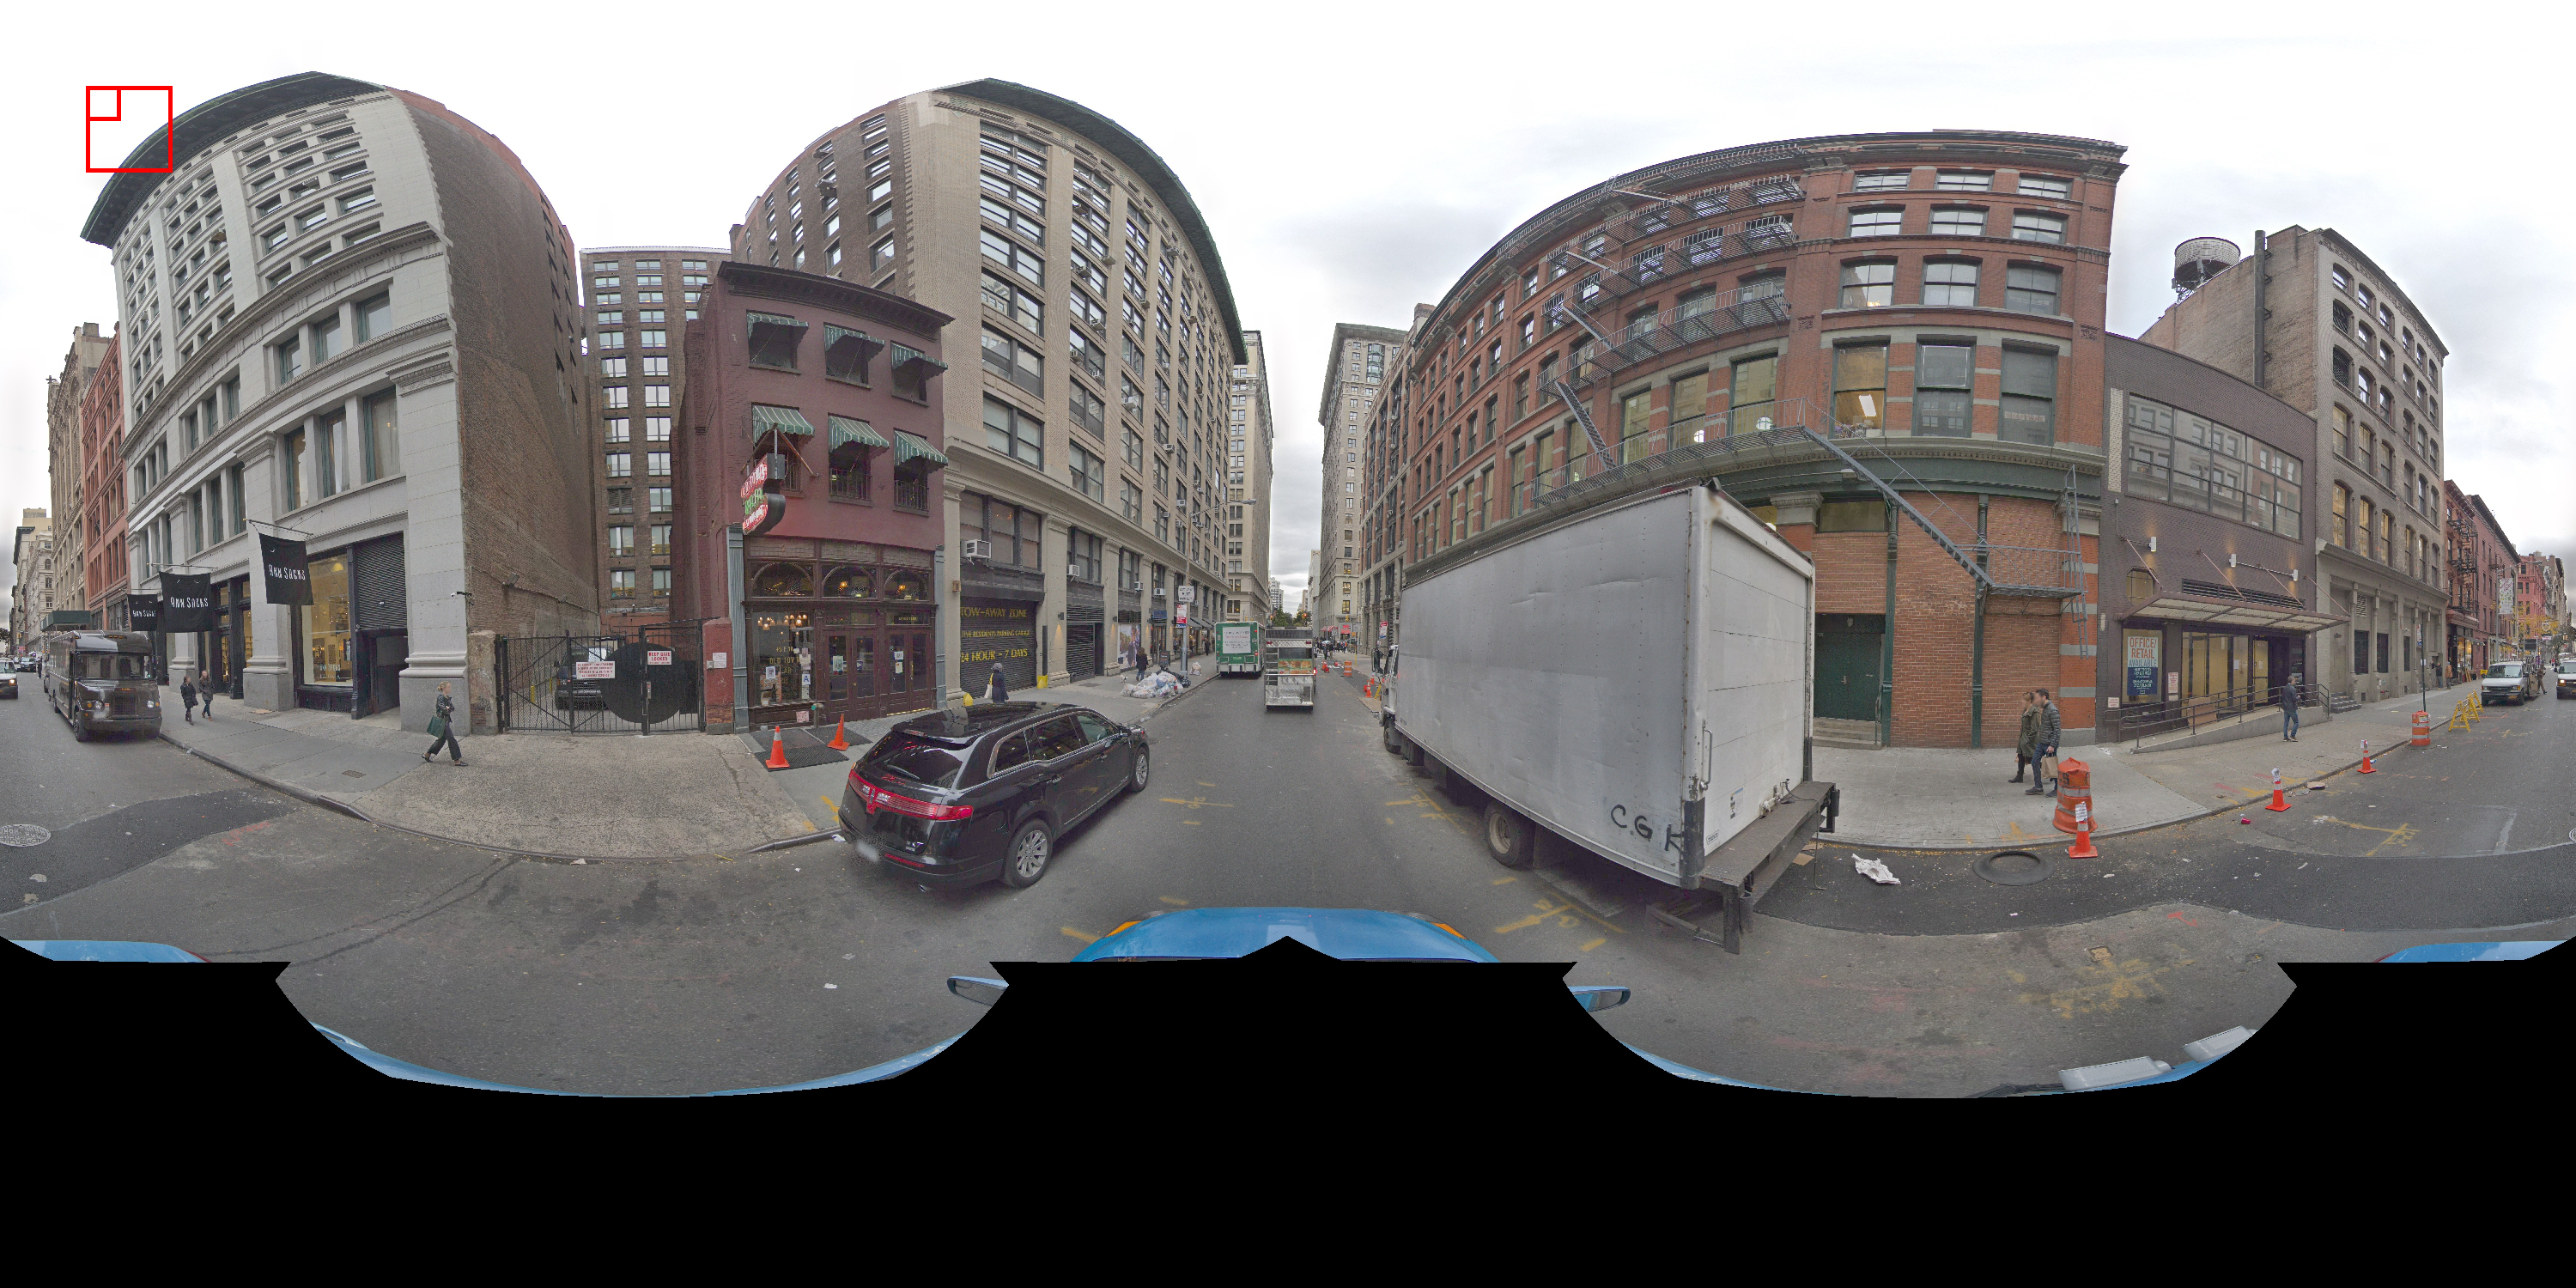

In [4]:
draw = ImageDraw.Draw(image)
draw.rectangle((100, 100, 200, 200), outline=(255, 0, 0), width=5)
image

In [3]:
# Mean, Std and Median of distances 
print(np.mean(distances_normal), np.std(distances_normal), np.median(distances_normal))
print(np.mean(distances_annotations), np.std(distances_annotations), np.median(distances_annotations))

526.486106791817 722.7413363798014 136.0
551.0997119143695 731.7310815322165 144.0


In [4]:

def intersection_within_k(dists1, dists2, k=40):
    '''
    Calculate the number of distances in dist1 and dist that lie within a k-threshold. Also calculate which examples of distances that are within k-threshold in both dis1 and dist2
    '''
    dists1 = np.array(dists1)
    dists2 = np.array(dists2)

    good_dists_1 = [1 if dists1[i] <= k else 0 for i in range(len(dists1))]
    good_dists_2 = [1 if dists2[i] <= k else 0 for i in range(len(dists2))]

    common = [1 if good_dists_1[i] == good_dists_2[i] else 0 for i in range(len(good_dists_1))]    


    return np.array(common), np.array(good_dists_1), np.array(good_dists_2)

common40, annotations40, normal40 = intersection_within_k(distances_annotations, distances_normal, 40)
common80, annotations80, normal80 = intersection_within_k(distances_annotations, distances_normal, 80)
common120, annotations120, normal120 = intersection_within_k(distances_annotations, distances_normal, 120)


In [51]:
( len(common40[common40 == 1]) / len(common40) )* 100
# 81 percent of cases where normal prediction gets things right, annotated prediction also gets it right. 

81.1646297627606

In [14]:
normButNotAnn = []
for i in range(len(annotations40)):
    if annotations40[i] == 0 and normal40[i] == 1:
        normButNotAnn.append(i)


In [5]:
annButNotNorm = []
for i in range(len(annotations40)):
    if annotations40[i] == 1 and normal40[i] == 0:
        annButNotNorm.append(i)


In [7]:
# Load bounding box annotations 
mode = 'dev'
annotations = np.load(f'/data2/saaket/annotations_{mode}_perspective.npy', allow_pickle=True)
# good_boxes = np.load('/data2/saaket/good_boxes_area_14400.npy')

In [4]:
mode = 'dev'
targets_array = np.load(f'/data1/saaket/lsd_data/data/processed/sdr_{mode}_perspective_targets_x_y.npy', allow_pickle=True)
def touchdown_loader(data_path):
    texts, panoids, targets = [], [], []
    with open(data_path) as f:
        for idx, line in enumerate(f):
            obj = json.loads(line)
            center = json.loads(obj['main_static_center'])
            panoids.append(obj['main_pano'])
            texts.append(obj['td_location_text'])
            targets.append(targets_array[idx][obj['main_pano']])
    return texts, panoids, targets 
texts, panoids, targets = touchdown_loader('/data1/saaket/touchdown/data/dev.json')

In [8]:
from matplotlib.pyplot import subplot, text


def get_pred_coords(pred):
    pred = (
                nn.functional.interpolate(
                    pred.unsqueeze(0).unsqueeze(0),
                    (800, 460*8),
                    mode="bilinear",
                )
                .float()
                .squeeze(0).squeeze(0)
            )
    pred_coord = np.unravel_index(pred.argmax(), pred.size())
    return pred_coord

def preds_to_xy(preds):
    row, col = preds
    slice_number = col // 460 
    col = col % 460

    x, y = col, row 
    return slice_number, x, y 


def visualize_touchdown(idx, preds_ann, preds_norm, targets, panoids, texts, annotations):
    # preds_ann_rc = get_pred_coords(preds_ann[idx])
    # preds_norm_rc = get_pred_coords(preds_norm[idx])
    # print(preds_ann_rc, preds_norm_rc)
    # slice_ann, x_ann, y_ann = preds_to_xy(preds_ann_rc)
    # slice_norm, x_norm, y_norm = preds_to_xy(preds_norm_rc)
    target_slice, target_x, target_y = targets[idx]
    images = []
    for i in range(8):
        images.append(cv2.cvtColor(cv2.imread(f"/data1/saaket/lsd_data/data/processed/pano_slices/{panoids[idx]}/{panoids[idx]}_{i}.jpg" ), cv2.COLOR_BGR2RGB))

    # cv2.circle(images[slice_ann], (x_ann, y_ann), 20, (255, 255, 255), -1)
    # cv2.circle(images[slice_norm], (x_norm, y_norm), 20, (0, 0, 0), -1)
    cv2.circle(images[target_slice], (target_x, target_y), 20, (255, 0, 0), -1)
    colors = [(255, 255, 0), (0, 255, 255), (255, 0, 255), (100, 100 ,100), (200, 200, 200)]
    for j ,ann in enumerate(annotations[idx]):
        s, b = ann 
        x1, y1, x2, y2 = b 
        # cv2.circle(images[s], (target_x, target_y), 10, (255, 0, 0), -1)
        cv2.rectangle(images[s], (x1, y1), (x2, y2), color=colors[j%5], thickness=5)

    f, axarr = plt.subplots(1, 8, figsize=(30, 20))
    
    axarr[0].imshow(images[0])
    axarr[1].imshow(images[1])
    axarr[2].imshow(images[2])
    axarr[3].imshow(images[3])
    axarr[4].imshow(images[4])
    axarr[5].imshow(images[5])
    axarr[6].imshow(images[6])
    axarr[7].imshow(images[7])
    display(texts[idx])
    

'a row of blue bikes, Touchdown is in the fifth bike seat in the row, from the way you came.'

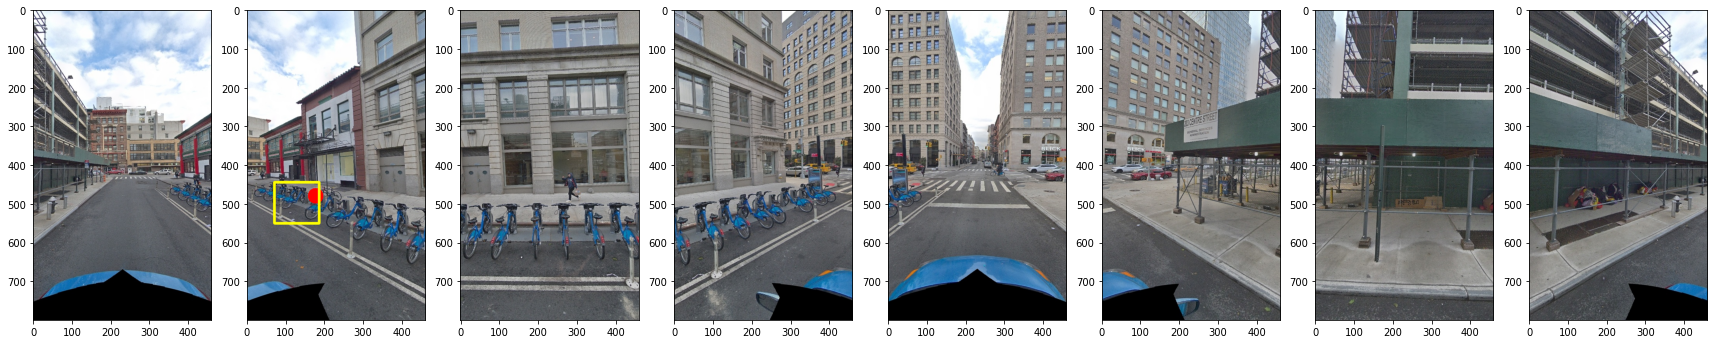

In [19]:
visualize_touchdown(idx=8, preds_ann=None, preds_norm=None, targets=targets, panoids=panoids, texts=texts, annotations=annotations)

In [10]:
visualize_touchdown(idx=1340, preds_ann=preds_annotations, preds_norm=preds_normal, targets=targets, panoids=panoids, texts=texts, annotations=annotations)

NameError: name 'preds_annotations' is not defined

In [10]:
annButNotNorm

[17,
 22,
 34,
 39,
 53,
 65,
 73,
 74,
 80,
 96,
 98,
 110,
 117,
 125,
 137,
 158,
 177,
 179,
 183,
 192,
 193,
 205,
 249,
 276,
 279,
 307,
 311,
 316,
 335,
 339,
 342,
 346,
 361,
 368,
 372,
 377,
 387,
 389,
 411,
 416,
 431,
 443,
 465,
 469,
 471,
 504,
 505,
 549,
 550,
 573,
 579,
 600,
 605,
 608,
 623,
 673,
 681,
 689,
 692,
 712,
 716,
 723,
 726,
 740,
 745,
 752,
 779,
 799,
 803,
 804,
 846,
 847,
 852,
 871,
 878,
 892,
 896,
 902,
 903,
 906,
 907,
 910,
 937,
 948,
 974,
 1022,
 1072,
 1079,
 1080,
 1081,
 1100,
 1109,
 1118,
 1129,
 1160,
 1162,
 1199,
 1204,
 1215,
 1233,
 1244,
 1255,
 1259,
 1292,
 1299,
 1301,
 1304,
 1321,
 1323,
 1330,
 1337,
 1340,
 1361,
 1378,
 1382,
 1389]

In [26]:
# percentage preds in correct slice 
def get_pred_coords(preds):
    pred_coords = []
    for i in tqdm(range(len(preds))):
        pred = preds[i]
        pred = (
                    nn.functional.interpolate(
                        pred.unsqueeze(0).unsqueeze(0),
                        (800, 460*8),
                        mode="bilinear",
                    )
                    .float()
                    .squeeze(0).squeeze(0)
                )
        pred_coord = np.unravel_index(pred.argmax(), pred.size())


        row, col = pred_coord
        slice_number = col // 460 
        x, y = col, row 
        pred_coords.append((slice_number, x, y))
    
    return pred_coords
#     target_slice, target_x, target_y = targets[i]

#     if slice_number == target_slice:
#         correct += 1
# print((correct / len(preds))*100)
pred_coords = get_pred_coords(preds)

 22%|██▏       | 312/1391 [00:10<00:37, 28.72it/s]


KeyboardInterrupt: 

In [13]:
targets[0]

(3, 241, 488)

In [11]:
def get_correct_slice_number(pred_coords, target_coords):
    correct = 0
    for i in range(len(pred_coords)):
        if pred_coords[i][0] == target_coords[i][0]:
            correct+=1
    return 100*(correct/len(pred_coords))

In [66]:
get_correct_slice_number(pred_coords, targets)

NameError: name 'get_correct_slice_number' is not defined

In [21]:
a = [1,2,3]
a[-1:]

[3]

In [28]:
len(annotations)

1298

In [6]:
def percentage_annotations_in_correct_slice(target_coords, annotations):
    correct = 0
    for i in range(len(target_coords)):
        ann_slices = [c[0] for c in annotations[i][:-1]]
        if target_coords[i][0] in ann_slices:
            correct+=1

    return 100*(correct/len(target_coords))
    

In [91]:
percentage_annotations_in_correct_slice(targets, annotations)

39.69348659003831

In [7]:
percentage_annotations_in_correct_slice(targets, annotations)

43.69348659003832

In [40]:
percentage_annotations_in_correct_slice(targets, annotations)

42.846872753414814

In [4]:
def get_area(box):
    x1, y1,  x2, y2 = box 

    return (x2-x1)*(y2-y1)

In [8]:
def euclidean_dist(x1, y1, x2, y2):
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

In [9]:
def inside_box(tx, ty, box):
    x1, y1, x2, y2 = box 

    if x1 <= tx <= x2 and y1 <= ty <= y2:
        return True 
    return False 

In [10]:
def point_to_box_dist(px, py, box):
    x1, y1, x2, y2 = box 
    dx = max([x1-px, 0, px-x2])
    dy = max([y1-py, 0, py-y2])

    return np.sqrt(dx**2 + dy**2)

In [31]:
def annotation_distance_from_touchdown(annotations, targets, mode='best'):
    distances = []
    boxes_with_target = []
    for i in range(len(annotations)):
        centers = []
        target_slice, target_x, target_y = targets[i]
        target_x = 460*target_slice + target_x 
        dist = []
        for sbox in annotations[i]:
            
            s, box = sbox 
            
            x1, y1, x2, y2 = box 
            x1 = s*460 + x1 
            x2 = s*460 + x2 

            # cx = (x1+x2)/2 
            # cy = (y1+y2)/2
            # if inside_box(target_x, target_y, box):
            #     dist.append(0)
            #     boxes_with_target.append(sbox)
            dist.append(point_to_box_dist(target_x, target_y, (x1, y1, x2, y2)))
            

        if mode == 'best':
            distances.append(min(dist))
        else:
            distances.extend(dist)
    return np.array(distances), boxes_with_target 

In [32]:
distances, bwt = annotation_distance_from_touchdown(annotations, targets, mode='best')

In [33]:
np.mean(distances)

345.05650900978696

In [34]:
len(distances[distances < 40])/len(targets), len(distances[distances < 80])/len(targets), len(distances[distances < 120])/len(targets)

(0.396117900790798, 0.47088425593098493, 0.5413371675053918)

In [16]:
areas = []
for sbox in bwt:
    s, box = sbox 
    areas.append(get_area(box))

In [17]:
areas = np.array(areas)

len(areas[areas < 120*120]) / len(annotations)

0.16950191570881226

In [18]:
distances = np.array(distances)

In [19]:
len(distances[distances < 120]) / len(annotations)

0.5089655172413793

In [20]:
len(distances[distances < 40]) / len(distances)

0.4217624521072797